In [232]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')
from matplotlib.ticker import MaxNLocator

from matplotlib import rc
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
colony_plot_data = pd.read_pickle("../../microcolony_analysis_giant_lorentz/cell_data_giant_lorentz.pickle")#pd.read_pickle("../../microcolony_analysis/microcolony_plotting_data.pickle")

colony_plot_data["Intensity foldchange"] = colony_plot_data["Mean observed intensity"]/colony_plot_data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()

def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

data = pd.read_pickle("../../microcolony_analysis/real_data_segmentation_notebooks/agar_pad_with_deconv.pickle")
max_sim_size = colony_plot_data["Colony N cells"].max()
data = data.query("`Colony N cells` <= @max_sim_size")
data["Distance from centre of colony"] = np.sqrt(
    (data["Cell y"] - data["Colony centroid y"])**2 + (data["Cell x"] - data["Colony centroid x"])**2 
)
data["Normalised distance from centre of colony"] = data["Distance from centre of colony"] / (data["Colony diameter"]/2)
data["Mean true intensity"] = data["True intensity"] / data["Area"]
data["Mean observed intensity"] = data["Observed intensity"] / data["Area"]

data["Mean deconvolved intensity"] = data["Deconvolved intensity"] / data["Area"]

data = data[(data["Mean true intensity"] > 0)]
data["Colony N cells (binned)"] = bin_data_range(bins = 3, df=data, column="Colony N cells", new_column_name="Colony N cells (binned)")
data["Normalised distance from centre of colony (binned)"] = bin_data_mid(bins=19, df = data, column = "Normalised distance from centre of colony", new_column_name=None)
div_frac = data.query("`Colony N cells` == 1")["Mean observed intensity"].mean() / colony_plot_data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()
data[column] = data["Mean observed intensity"]*0.0025
data["Intensity foldchange"] = data[column] / data.query("`Colony N cells` == 1")["Mean observed intensity"].mean()# 4.2*0.003



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
%%time

import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde 

# Create a kernel density estimate of the target distribution
target_distribution = gaussian_kde(data['Colony N cells'], bw_method=0.021)

data_to_sample = colony_plot_data#.sample(frac=0.02)
# Calculate the probability of each row in 'data' based on this distribution
probabilities = target_distribution(data_to_sample['Colony N cells'])



# Normalize probabilities
probabilities /= probabilities.sum()

# Resample 'data' dataframe to match the target distribution
resampled_data = data_to_sample.sample(n=len(data_to_sample), replace=True, weights=probabilities) # Synth data

# Do the same for 'colony_plot_data' if needed
print(resampled_data["Colony N cells"].mean())
print(data["Colony N cells"].mean())

print(resampled_data["Colony N cells"].var())
print(data["Colony N cells"].var())

94.3012138555937
96.205272652467
24924.41679816968
28076.5150209386
CPU times: user 2min 10s, sys: 1.47 s, total: 2min 12s
Wall time: 2min 10s


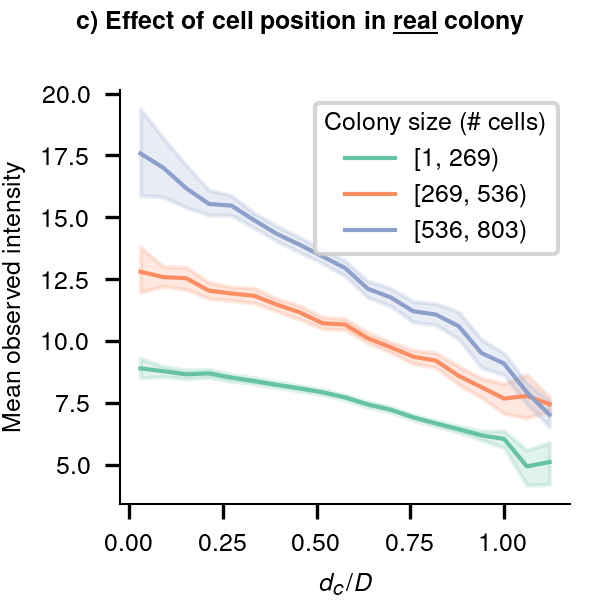

In [260]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 300)

sns.lineplot(
    data = data.query("`Colony N cells` > 20 "),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99),  ax = ax, palette="Set2"
)
plt.xlabel("$d_c$/$D$")
handles, labels = ax.get_legend_handles_labels()
labels[1], labels[2] = labels[2], labels[1]
ax.legend(handles, labels, title="Colony size (\# cells)")
plt.suptitle(r"\textbf{c) Effect of cell position in \underline{real} colony}", fontsize = 6)

fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("d.svg")

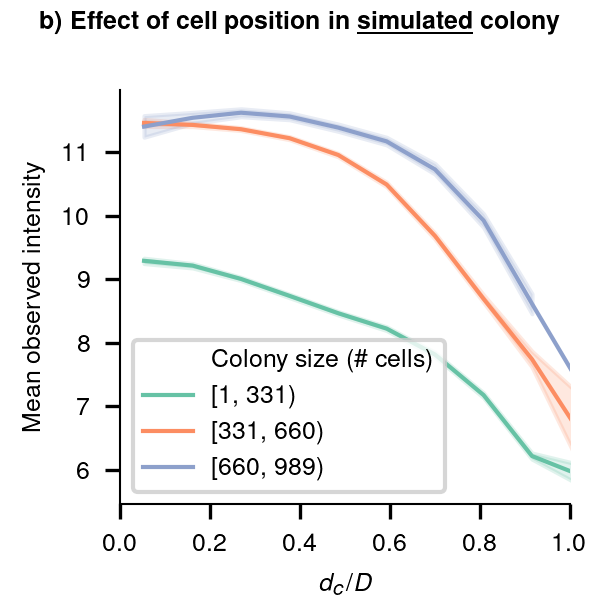

In [261]:
fig, DISTANCE_CELLS = plt.subplots(1,1, figsize=(2,2), dpi = 300)


sns.lineplot(
    data = resampled_data.query("`Colony N cells` > 20 & `True CV` < 0.05 & `NA` == 'Empirical 1.49' & `Normalised distance from centre of colony` <= 1"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), 
    style="NA", palette="Set2", 
)

handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles = []
filtered_labels = []

for handle, label in zip(handles, labels):
    if "NA" not in label and "Empirical" not in label:
        filtered_handles.append(handle)
        if label == "Colony N cells (binned)":
            filtered_labels.append("Colony size (\# cells)")
        else:
            filtered_labels.append(label)

plt.legend(filtered_handles, filtered_labels)

plt.xlabel("$d_c$/$D$")
plt.xlim(0,1)
plt.suptitle(r"\textbf{b) Effect of cell position in \underline{simulated} colony}", fontsize=6)
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("b.svg")

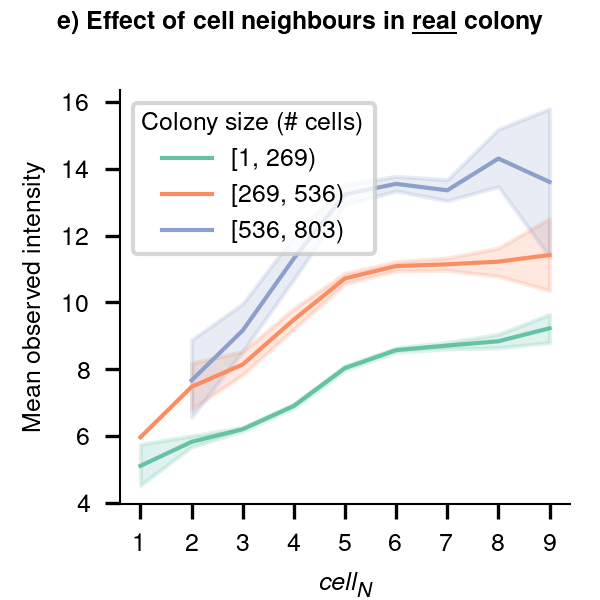

In [234]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 300)

sns.lineplot(
    data = data.query("`Colony N cells` > 20 & `N neighbours` < 10 "),
    x = "N neighbours",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99), ax = ax, palette="Set2"
)

plt.xlabel("$cell_N$")
x_max = 9
ax.set_xticks(np.arange(0, x_max + 1, 1))

fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)

# Get existing legend
legend = ax.legend_

# Rename legend title
legend.set_title("Colony size (\# cells)")

# Swap 2nd and 3rd labels
handles, labels = ax.get_legend_handles_labels()
labels[1], labels[2] = labels[2], labels[1]
plt.xlim(0.6,)
# Reconstruct legend
ax.legend(handles, labels, title="Colony size (\# cells)")
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.suptitle(r"\textbf{e) Effect of cell neighbours in"+r" \underline{real} colony}", fontsize=6)
plt.savefig("e.svg")

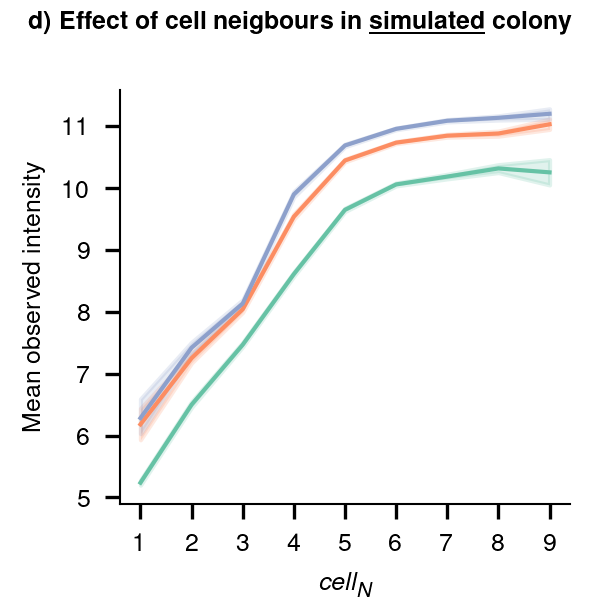

In [236]:
fig, INTENSITY_VS_N_NEIGHBOURS = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

sns.lineplot(
    data=colony_plot_data.query("`Colony N cells` > 0 & `True CV` < 0.05 & `NA` == 'Empirical 1.49' & `N neighbours` < 10"),
    x="N neighbours",
    y="Mean observed intensity",
    hue="Colony N cells (binned)",
    errorbar=('ci', 99),
    style="NA", palette="Set2", legend=None
)

# Set x-axis to have integer ticks
INTENSITY_VS_N_NEIGHBOURS.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("$cell_N$")
plt.suptitle(r"\textbf{d) Effect of cell neigbours in \underline{simulated} colony}", fontsize=6, usetex=True)
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("c.svg")

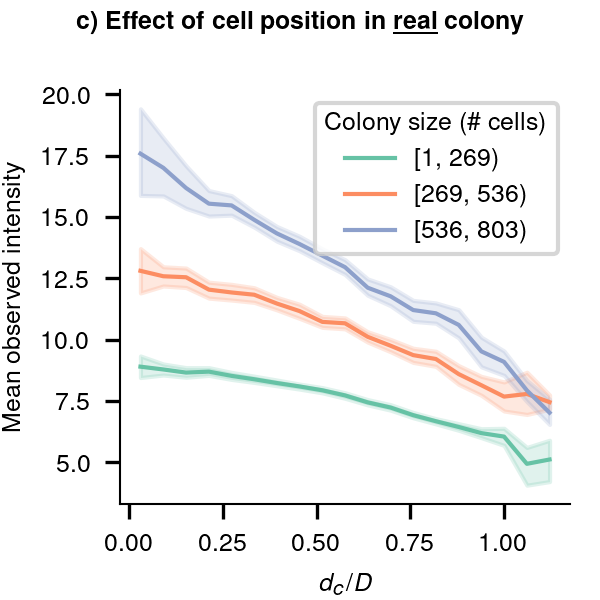

In [237]:
fig, ax = plt.subplots(1,1, figsize=(2,2), dpi = 300)

sns.lineplot(
    data = data.query("`Colony N cells` > 20 "),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Colony N cells (binned)",
    errorbar=('ci', 99),  ax = ax, palette="Set2"
)
plt.xlabel("$d_c$/$D$")
handles, labels = ax.get_legend_handles_labels()
labels[1], labels[2] = labels[2], labels[1]
ax.legend(handles, labels, title="Colony size (\# cells)")
plt.suptitle(r"\textbf{c) Effect of cell position in \underline{real} colony}", fontsize = 6)

fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("d.svg")

In [238]:
resampled_data["Data Type"] = "Simulated Data"
data["Data Type"] = "Real Data"

In [239]:
combined_data = pd.concat([resampled_data, data])

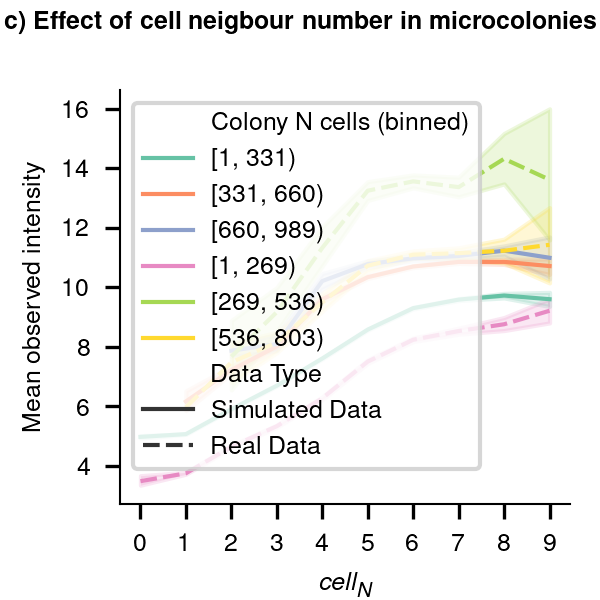

In [259]:
fig, INTENSITY_VS_N_NEIGHBOURS = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

sns.lineplot(
    data=combined_data.query(" `N neighbours` < 10 & (`True CV` < 0.05 or `Data Type` == 'Real Data' or `Colony N cells` == 1)"),
    x="N neighbours",
    y="Mean observed intensity",
    hue="Colony N cells (binned)",
    style = "Data Type",
    errorbar=('ci', 99), palette="Set2"
)

# Set x-axis to have integer ticks
INTENSITY_VS_N_NEIGHBOURS.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("$cell_N$")
plt.suptitle(r"\textbf{c) Effect of cell neigbour number in microcolonies}", fontsize=6, usetex=True)
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)


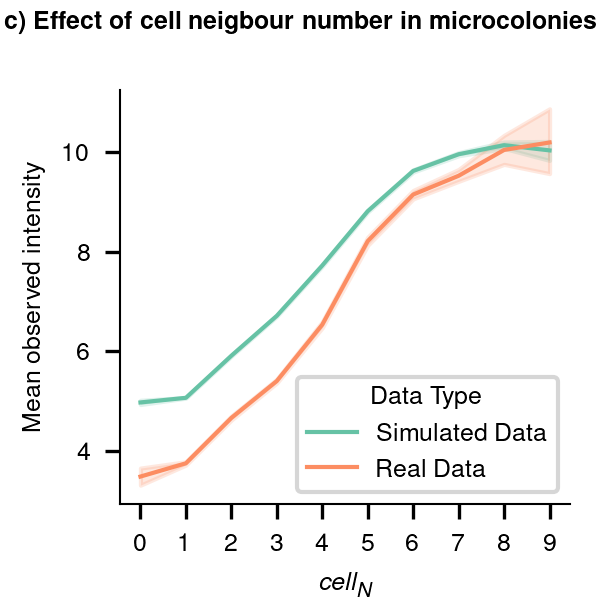

In [249]:
fig, INTENSITY_VS_N_NEIGHBOURS = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

sns.lineplot(
    data=combined_data.query(" `N neighbours` < 10 & (`True CV` < 0.05 or `Data Type` == 'Real Data' or `Colony N cells` == 1)"),
    x="N neighbours",
    y="Mean observed intensity",
    hue="Data Type",
    errorbar=('ci', 99), palette="Set2"
)

# Set x-axis to have integer ticks
INTENSITY_VS_N_NEIGHBOURS.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlabel("$cell_N$")
plt.suptitle(r"\textbf{c) Effect of cell neigbour number in microcolonies}", fontsize=6, usetex=True)
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("c.svg")

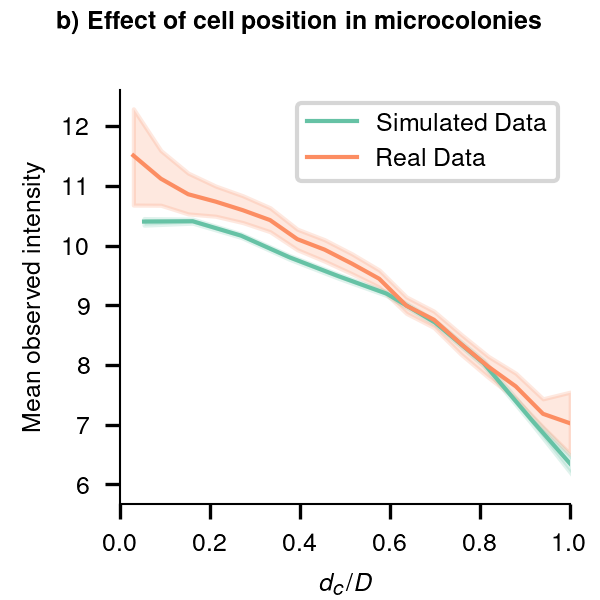

In [250]:
fig, DISTANCE_CELLS = plt.subplots(1,1, figsize=(2,2), dpi = 300)


sns.lineplot(
    data = combined_data.query("`Colony N cells` > 40 & `Normalised distance from centre of colony` <= 1 & (`True CV` < 0.05 or `Data Type` == 'Real Data' )"),
    x = "Normalised distance from centre of colony (binned)",
    y = "Mean observed intensity",
    hue = "Data Type",
    errorbar=('ci', 99), palette="Set2", 
)

handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles = []
filtered_labels = []

for handle, label in zip(handles, labels):
    if "NA" not in label and "Empirical" not in label:
        filtered_handles.append(handle)
        if label == "Colony N cells (binned)":
            filtered_labels.append("Colony size (\# cells)")
        else:
            filtered_labels.append(label)

plt.legend(filtered_handles, filtered_labels)

plt.xlabel("$d_c$/$D$")
plt.xlim(0,1)
plt.suptitle(r"\textbf{b) Effect of cell position in microcolonies}", fontsize=6)
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("b.svg")

In [253]:
combined_data.query("`Colony N cells` > 40 & `Normalised distance from centre of colony` <= 1 & (`True CV` < 0.05 or `Data Type` == 'Real Data' )")["Colony N cells"].max()

812

# Part 2

In [263]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])
from matplotlib_scalebar.scalebar import ScaleBar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from numba import njit

@njit
def get_CV(arr):
    return arr.std()/arr.mean()


@njit()
def get_intensities(img, mask):
    mask_labels = np.unique(mask)
    mean_intensities = []
    total_intensities = []
    for l, mask_label in enumerate(mask_labels[1:]):
        idxs = np.where(mask == mask_label)
        if len(idxs[0]) > 100:
            pixel_intensities = np.zeros(len(idxs[0]))
            for k, (i, j) in enumerate(zip(idxs[0], idxs[1])):
                pixel_intensities[k] = img[i,j]
            mean_intensity = np.mean(pixel_intensities)
            total_intensity = np.sum(pixel_intensities)
            mean_intensities.append(mean_intensity)
            total_intensities.append(total_intensity)
    mean_intensities = np.array(mean_intensities)
    total_intensities = np.array(total_intensities)
    return mean_intensities, total_intensities


def get_CV_from_img_mask(img, mask):
    mean_intensities, total_intensities = get_intensities(img,mask)
    return get_CV(mean_intensities), get_CV(total_intensities)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_10470/2375448902.py:59: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


/tmp/ipykernel_10470/2517242481.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  a = matplotlib.cm.get_cmap('Set2')


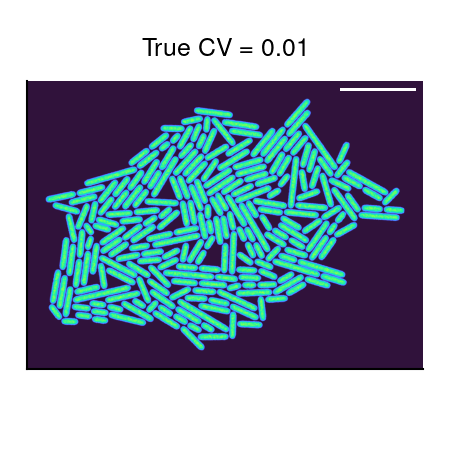

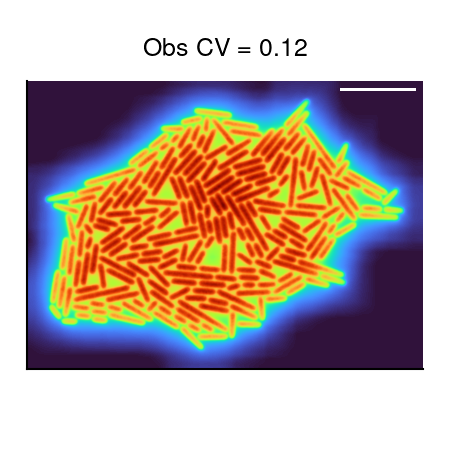

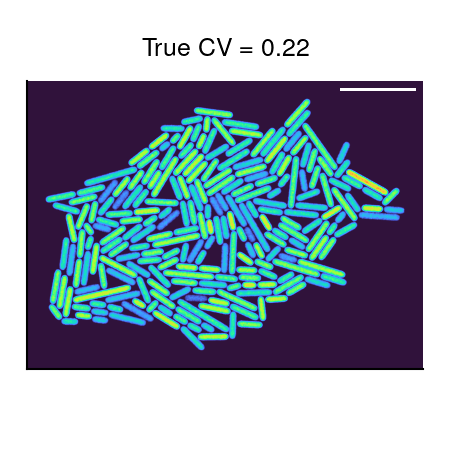

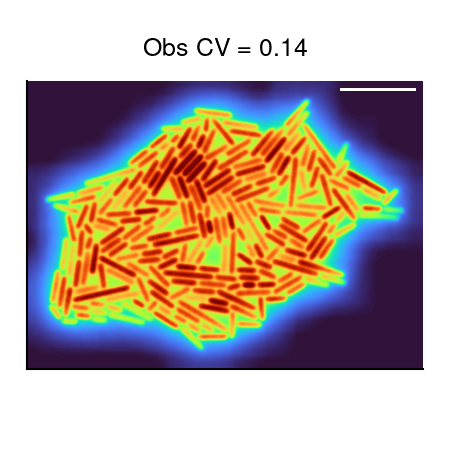

In [264]:
colony_ID_low_CV = 315
colony_ID_high_CV = colony_ID_low_CV + 2844

low_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_low_CV+1).zfill(5)}.tif").sum(axis=0)
high_CV_unconv = tifffile.imread(f"../../microcolony_analysis/data/fluorescent_scenes_3D//{str(colony_ID_high_CV+1).zfill(5)}.tif").sum(axis=0)
low_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518//synth_imgs/{str(colony_ID_low_CV).zfill(4)}.tif")
high_CV_conv = tifffile.imread(f"../../microcolony_analysis/simulated_colonies_empirical_PSF/training_data_100x_0.55_green_1.49_1.518/synth_imgs/{str(colony_ID_high_CV).zfill(4)}.tif")


colony_plot_data = pd.read_pickle("../../microcolony_analysis/microcolony_plotting_data.pickle")

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

CV_low_CV_conv = get_CV_from_img_mask(low_CV_conv, mask)[0]

#mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_low_CV+1).zfill(5)}.png"))

CV_low_CV_unconv = get_CV_from_img_mask(low_CV_unconv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_high_CV+1).zfill(5)}.png"))

CV_high_CV_conv =  get_CV_from_img_mask(high_CV_conv, mask)[0]

mask = np.array(Image.open(f"../../microcolony_analysis/data/masks//{str(colony_ID_high_CV+1).zfill(5)}.png"))

CV_high_CV_unconv = get_CV_from_img_mask(high_CV_unconv, mask)[0]




cmap="turbo"


cm = 1/2.54
a = matplotlib.cm.get_cmap('Set2')

fig, LOW_CV_UNCONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(gaussian_filter(low_CV_unconv,1), cmap=cmap, vmin=0, vmax = high_CV_unconv.max()*0.9  )
#LOW_CV_UNCONV.annotate( f'True CV = {CV_low_CV_unconv:.2f}', (1030,768), ha='right', va='top', transform=LOW_CV_UNCONV.transAxes, c="black")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
LOW_CV_UNCONV.add_artist(scalebar)
LOW_CV_UNCONV.set_xticks([])
LOW_CV_UNCONV.set_yticks([])
plt.title(f'True CV = {CV_low_CV_unconv:.2f}')
plt.tight_layout()
plt.savefig("f.svg")
plt.show()
plt.close() 

fig, LOW_CV_CONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(low_CV_conv, cmap=cmap, vmin=0,vmax = high_CV_conv.max()*0.9 ) 
#LOW_CV_CONV.annotate( f'Obs CV = {CV_low_CV_conv:.2f}', (1030,650), ha='right', va='top', transform=LOW_CV_CONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
LOW_CV_CONV.add_artist(scalebar)
LOW_CV_CONV.set_xticks([])
LOW_CV_CONV.set_yticks([])
plt.title(f'Obs CV = {CV_low_CV_conv:.2f}')
plt.tight_layout()
plt.savefig("g.svg")
plt.show()
plt.close()

fig, HIGH_CV_UNCONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(gaussian_filter(high_CV_unconv,1), cmap=cmap, vmin=0, vmax = high_CV_unconv.max()*0.9)
#HIGH_CV_UNCONV.annotate( f'True CV = {CV_high_CV_unconv:.2f}', (1030,650), ha='right', va='top', transform=HIGH_CV_UNCONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
HIGH_CV_UNCONV.add_artist(scalebar)
HIGH_CV_UNCONV.set_xticks([])
HIGH_CV_UNCONV.set_yticks([])
plt.title(f'True CV = {CV_high_CV_unconv:.2f}')
plt.tight_layout()
plt.savefig("h.svg")
plt.show()
plt.close()

fig, HIGH_CV_CONV  = plt.subplots(1,1, figsize=(1.5,1.5), dpi = 300)
plt.imshow(high_CV_conv, cmap=cmap, vmin=0,vmax = high_CV_conv.max()*0.9 )
#HIGH_CV_CONV.annotate( f'Obs CV = {CV_high_CV_conv:.2f}', (1030,650), ha='right', va='top', transform=HIGH_CV_CONV.transAxes, c="white")
scalebar = ScaleBar(0.05, "um", label_loc=None, scale_loc = "none", box_alpha=0, color="white", length_fraction=0.25) # 10 micron
HIGH_CV_CONV.add_artist(scalebar)
HIGH_CV_CONV.set_xticks([])
HIGH_CV_CONV.set_yticks([])
plt.title(f'Obs CV = {CV_high_CV_conv:.2f}')
plt.tight_layout()
plt.savefig("i.svg")
plt.show()
plt.close()

/tmp/ipykernel_10470/1704280525.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.scatterplot(


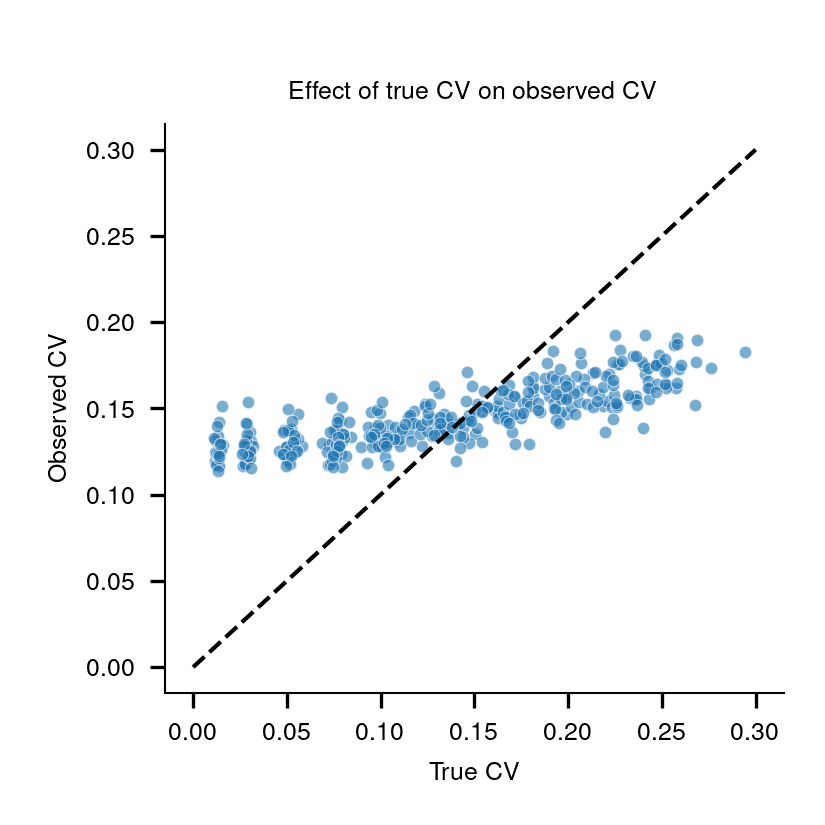

In [265]:
fig, CVPLOT = plt.subplots(1,1, figsize=(2.75,2.75), dpi = 300)
g = sns.scatterplot(
    data=colony_plot_data.drop_duplicates(["Colony ID", "NA","Wavelength"]).query("`Wavelength` == 0.55 & NA != 0.95 & `Colony N cells` > 150 & `NA` == 'Empirical 1.49'"), 
    x="True CV", 
    y = "Observed CV", 
    alpha=0.6, palette="icefire", legend = None
)
g.axes.plot([0,0.3],[0,0.3], c="k", linestyle="--")
plt.title("Effect of true CV on observed CV")
fig.subplots_adjust(left=0.2, bottom=0.16, right=0.95, top=0.85)
plt.savefig("j.svg")
plt.show()
plt.close()


In [266]:
import seaborn as sns
synth_data = pd.read_pickle("../../microcolony_analysis_giant_lorentz/cell_data_giant_lorentz.pickle").sample(frac = 0.002, random_state=4)

synth_data['abs_diff'] = (synth_data['True CV'] - synth_data['Deconvolved CV real PSF']).abs()

# Filter rows where the absolute difference is less than or equal to 0.1
synth_data = synth_data[synth_data['abs_diff'] <= 0.1]

# Optionally, drop the 'abs_diff' column if you don't need it anymore
synth_data = synth_data.drop(columns=['abs_diff'])

In [267]:
synth_data['abs_diff'] = (synth_data['True CV'] - synth_data['Deconvolved CV real PSF']).abs()

# Filter rows where the absolute difference is less than or equal to 0.1
synth_data = synth_data[synth_data['abs_diff'] <= 0.1]

# Optionally, drop the 'abs_diff' column if you don't need it anymore
synth_data = synth_data.drop(columns=['abs_diff'])

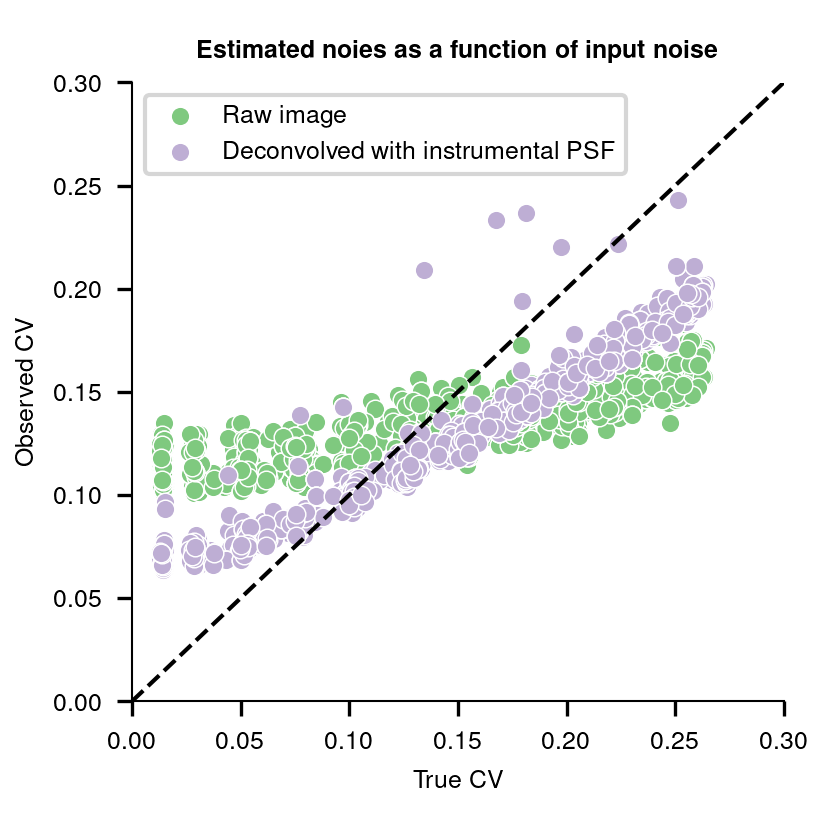

In [283]:
fig, ax = plt.subplots(figsize=(2.75,2.75), dpi = 300)
sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Observed CV", ax=ax,  s=20, label = "Raw image", color = "#7fc97f")  # Adjusted for size (s=20) and alpha
sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Deconvolved CV real PSF", ax=ax,  s=20, label = "Deconvolved with instrumental PSF", color = "#beaed4")
#sns.scatterplot(data=synth_data.query("`Colony N cells` > 200"), x="True CV", y="Deconvolved CV large PSF", ax=ax,  s=20, label = "Deconvolved with large effective PSF")
plt.title(r"\textbf{Estimated noies as a function of input noise}")
plt.plot([0,0.7], [0,0.7], c = "k", linestyle="--")
plt.legend()
plt.xlim(0,0.3)
plt.ylim(0,0.3)
fig.subplots_adjust(left=0.16, right=0.95, top = 0.9, bottom = 0.15)
plt.savefig("g.svg")